### ii. Test all the data in the test database with k nearest neighbors. Take decisions by majority polling. Plot train and test errors in terms of k for  k ∈ {208, 205, .....7, 4, 1}  (in reverse order). You are welcome to use smaller increments of k. Which k∗ is the most suitable k among those values? Calculate the confusion matrix, true positive rate, true negative rate, precision, and F-score when k = k∗.

In [1]:
import numpy as np

CLASS0 = "class 0"
CLASS1 = "class 1"
EPSILON = 1e-8

def load_data(file_path):
	"""read records from csv file"""
	row_data = np.genfromtxt(file_path, dtype=None, delimiter=',', encoding='utf-8')[1:]
	X = np.array(row_data[:, :-1], dtype=float)
	Y_row_str_data = row_data[:, row_data.shape[1] - 1]
	y = np.array([1 if x == "Abnormal" else 0 for x in Y_row_str_data])
	# print(X)
	# print(y)
	return X, y

def train_test_by_class_index(X, y, split_info_dict):
	"""According to the dict, split row data into X_train, X_test, y_train, y_test"""
	assert X.shape[0] == y.shape[0], \
		"the size of X must be equal to the size of y"
	assert split_info_dict is not None, \
		"Please initialize a dict with {CLASS0: int, CLASS1: int}"
	
	normal_indexes = (y == 0)
	abnormal_indexes = (y == 1)
	normal_limit = split_info_dict[CLASS0]
	abnormal_limit = split_info_dict[CLASS1]

	'''first 70 rows of class 0'''
	X_data_normal = X[normal_indexes, :][:normal_limit]
	y_data_normal = y[normal_indexes][:normal_limit]

	'''the rest of data in class 0'''
	X_rest_data_normal = X[normal_indexes, :][normal_limit:]
	y_rest_data_normal = y[normal_indexes][normal_limit:]

	'''first 140 rows of class 1'''
	X_data_abnormal = X[abnormal_indexes, :][:abnormal_limit]
	y_data_abnormal = y[abnormal_indexes][:abnormal_limit]
	'''the rest of data in class 1'''
	X_rest_data_abnormal = X[abnormal_indexes, :][abnormal_limit:]
	y_rest_data_abnormal = y[abnormal_indexes][abnormal_limit:]

	'''combine them into one array'''
	X_train = np.concatenate((X_data_normal, X_data_abnormal), axis=0)
	X_test = np.concatenate((X_rest_data_normal, X_rest_data_abnormal), axis=0)

	y_train = np.concatenate((y_data_normal, y_data_abnormal), axis=0)
	y_test = np.concatenate((y_rest_data_normal, y_rest_data_abnormal), axis=0)

	return X_train, X_test, y_train, y_test

In [2]:
def accuracy_score(y_true, y_predict):
	'''compare every single item in each array'''
	assert y_true.shape[0] == y_predict.shape[0], \
		"the shape of y_true need to be identical with y_predict"
	return sum(y_true == y_predict) / len(y_true)

In [3]:
from math import sqrt
from collections import Counter

class KNeighborsClassifier:

	def __init__(self, n_neighbors):
		assert n_neighbors >= 1, "n_neighbors must be a valid number"
		self.n_neighbors = n_neighbors
		self._X_train = None
		self._y_train = None

	def fit(self, X_train, y_train):
		assert X_train.shape[0] == y_train.shape[0], ""
		assert self.n_neighbors <= X_train.shape[0], ""
		self._y_train = y_train
		self._X_train = X_train
		return self

	def predict(self, X_test):
		assert self._X_train is not None and self._y_train is not None, ""
		assert X_test.shape[1] == self._X_train.shape[1], ""

		y_predict = [self._predict(x) for x in X_test]
		return np.array(y_predict)

	def _predict(self, x):
		assert x.shape[0] == self._X_train.shape[1], ""
		# Euclidean Distance metric ==> sqrt(sum((x - y)^2))
		distances = [sqrt(np.sum(item - x) ** 2) for item in self._X_train]
		nearest = np.argsort(distances)
		topK_y = [self._y_train[i] for i in nearest[:self.n_neighbors]]
		votes = Counter(topK_y)
		return votes.most_common(1)[0][0]

	def score(self, X_test, y_test):
		y_predict = self.predict(X_test)
		return accuracy_score(y_test, y_predict)

	def __repr__(self):
		return "KNN(n_neighbors = %d)" % self.n_neighbors

In [4]:
import matplotlib.pyplot as plt

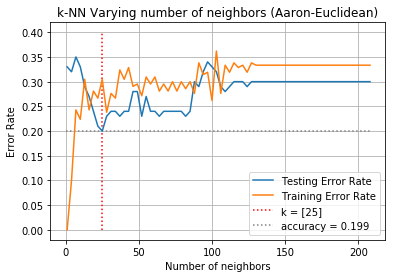

In [5]:
# find the best k based on Aaron KNN algorithm
X_row_data, Y_row_data = load_data('./assets/data.csv')

split_info_dict = {CLASS0: 70, CLASS1: 140}

# Aaron's split method
X_train, X_test, y_train, y_test = train_test_by_class_index(X_row_data, Y_row_data, split_info_dict)

alternative_k = np.arange(208, 0, -3)
train_accuracy = np.empty(len(alternative_k))
test_accuracy = np.empty(len(alternative_k))

for index, k in enumerate(alternative_k):
    # KNeighborsClassifier based on Euclidean Distance
    knn_clf = KNeighborsClassifier(n_neighbors=k)

    knn_clf.fit(X_train, y_train)

    y_predict = knn_clf.predict(X_test)

    train_accuracy[index] = knn_clf.score(X_train, y_train)

    test_accuracy[index] = knn_clf.score(X_test, y_test)

best_accuracy_ = np.max(test_accuracy)
best_k_ = 208 - (np.reshape(np.argwhere(test_accuracy == best_accuracy_), (1, -1))[0]) * 3
plt.title('k-NN Varying number of neighbors (Aaron-Euclidean)')
plt.plot(alternative_k, 1 - test_accuracy, label='Testing Error Rate')
plt.plot(alternative_k, 1 - train_accuracy, label='Training Error Rate')
plt.vlines(best_k_, 0, 0.4, colors='red', label='k = ' + str(best_k_),linestyles='dotted')
plt.hlines(1 - best_accuracy_, 0, 208, colors='gray', label='accuracy = ' + str(1 - best_accuracy_)[:5], linestyles='dotted')
plt.legend()
plt.grid(True)
plt.xlabel('Number of neighbors')
plt.ylabel('Error Rate')
plt.show()

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import pandas as pd

k = 25
knn_clf = KNeighborsClassifier(n_neighbors=k)
knn_clf.fit(X_train, y_train)
y_predict = knn_clf.predict(X_test)

confusion_matrix(y_test, y_predict)
crosstab = pd.crosstab(y_test, y_predict, rownames=['True'], colnames=['Predicted'], margins=True)
true_positive = crosstab.loc[[0]].values[0][0]
false_positive = crosstab.loc[[0]].values[0][1]
false_negative = crosstab.loc[[1]].values[0][0]
true_negative = crosstab.loc[[1]].values[0][1]
print("Aaron-Euclidean Distance k = ", k)
print("-----------------------------------------------------")
print(crosstab)
print("-----------------------------------------------------")

print("true_positive_rate(TPR) = ", true_positive / (true_positive + false_negative))
print("true_negative_rate(TNR) = ", true_negative / (false_positive + true_negative))
print("-----------------------------------------------------")

print(classification_report(y_test, y_predict))

Aaron-Euclidean Distance k =  25
-----------------------------------------------------
Predicted   0   1  All
True                  
0          14  16   30
1           4  66   70
All        18  82  100
-----------------------------------------------------
true_positive_rate(TPR) =  0.7777777777777778
true_negative_rate(TNR) =  0.8048780487804879
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.47      0.58        30
           1       0.80      0.94      0.87        70

   micro avg       0.80      0.80      0.80       100
   macro avg       0.79      0.70      0.73       100
weighted avg       0.80      0.80      0.78       100

